# COVID-19 Graphs

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from matplotlib import ticker 
from datetime import timedelta
import world_bank_data as wb
import pycountry
import math
from io import StringIO
%matplotlib inline

# This style file resets matplotlib to a half-decent basic style.
# Further tweaking is, unfortunately, still required.
plt.style.use("../russ.mplstyle")
plt.rcParams["figure.figsize"] = (18,10)

In [45]:
def update_rows(source, dest):
    for index, row in source.iterrows():
        try:
            dest.loc[index, 'total_cases'] = row['total_cases']
            if row.get('total_deaths'):
                dest.loc[index, 'total_deaths'] = row['total_deaths']
        except KeyError:
            dest.loc[index] = row

data = pd.read_csv('https://cowid.netlify.com/data/ecdc/full_data.csv',
                  parse_dates=[0])

data_updated = {}
data_updated['owid'] = data['date'].max().date()

data = data.drop(columns=['new_cases', 'new_deaths']).set_index(['location', 'date'])

uk_data = pd.read_excel('https://www.arcgis.com/sharing/rest/content/items/e5fd11150d274bebaaf8fe2a7a2bda11/data',
                       parse_dates=[0])\
            .rename(columns={'DateVal': 'date', 'CumCases': 'total_cases'}).drop(columns=['CMODateCount'])

data_updated['uk'] = uk_data['date'].max().date()

#uk_data.insert(1, 'location', 'United Kingdom')
#uk_data = uk_data.set_index(['location', 'date'])
#update_rows(uk_data, data)

us_data = (pd.read_csv(StringIO(requests.get('http://covidtracking.com/api/us/daily.csv').text), parse_dates=[0])
            .rename(columns={'positive': 'total_cases', 'death': 'total_deaths'})
            .drop(columns=['states', 'negative', 'posNeg', 'pending', 'total']))

data_updated['us'] = us_data['date'].max().date()

us_data.insert(1, 'location', 'United States')
us_data = us_data.set_index(['location', 'date'])
update_rows(us_data, data)


data = data.reset_index().sort_values('date').set_index(['location', 'date'])
print(data_updated)


{'owid': datetime.date(2020, 3, 21), 'uk': datetime.date(2020, 3, 20), 'us': datetime.date(2020, 3, 20)}


In [48]:
data.loc['Qatar']

,total_cases,total_deaths
date,,
2019-12-31,0.0,0.0
2020-01-01,0.0,0.0
2020-01-02,0.0,0.0
2020-01-03,0.0,0.0
2020-01-04,0.0,0.0
...,...,...
2020-03-17,439.0,0.0
2020-03-18,442.0,0.0
2020-03-19,452.0,0.0


In [11]:
def by_country(df):
    df = df.groupby(['location', 'date']).sum().reset_index()
    return df

bc = by_country(data)
#bc['location'].unique()
bc[bc['location'] == 'United Kingdom']
#data.loc['United Kingdom']

,location,date,total_cases,total_deaths
5739,United Kingdom,2019-12-31,0.0,0.0
5740,United Kingdom,2020-01-01,0.0,0.0
5741,United Kingdom,2020-01-02,0.0,0.0
5742,United Kingdom,2020-01-03,0.0,0.0
5743,United Kingdom,2020-01-04,0.0,0.0
...,...,...,...,...
5816,United Kingdom,2020-03-17,1950.0,55.0
5817,United Kingdom,2020-03-18,2626.0,60.0
5818,United Kingdom,2020-03-19,3269.0,103.0
5819,United Kingdom,2020-03-20,3983.0,144.0


In [12]:
country_mapping = {'UK': 'GBR', 'Mainland China': 'CHN',
                   'Republic of Ireland': 'IRL', 'Iran (Islamic Republic of)': 'IRN',
                   'Taiwan*': 'TWN', 'South Korea': 'KOR'}
for country in bc['location'].unique():
    if country in country_mapping:
        continue
    try:
        country_mapping[country] = pycountry.countries.search_fuzzy(country)[0].alpha_3
    except LookupError:
        print("Not found", country)

Not found Cape Verde
Not found Democratic Republic of Congo
Not found Faeroe Islands
Not found International
Not found Netherlands Antilles
Not found Swaziland
Not found World


In [13]:
def fetch_population():
    pop = wb.get_series('SP.POP.TOTL', id_or_value='id', simplify_index=True, mrv=1)
    return {country: pop.get(iso3, np.nan) for country, iso3 in country_mapping.items()}

population = fetch_population()

In [43]:
def by_relative_date(df, key='location', val_col='total_cases', threshold=100, past_days=10, future_days=None):
    ref_dates = {}
    for country in df[key].unique():
        series = df[df[key] == country]
        if series[val_col].max() < threshold:
            continue
        ref_dates[country] = series[series[val_col] >= threshold].iloc[0]['date']

    df.insert(1, 'reltime', np.nan)
    for index, row in df.iterrows():
        if row[key] not in ref_dates:
            continue
        reltime = row['date'] - ref_dates[row[key]]
        if reltime < timedelta(days=-past_days):
            df.drop(index, inplace=True)
        elif future_days is not None and reltime > timedelta(days=future_days):
            df.drop(index, inplace=True)
        else:
            df.loc[index, 'reltime'] = reltime
    return df


def extract_country(df, country, relative=False):
    val_col = df.columns[-1]
    df = df[df['location'] == country].drop(columns=['location'])
    if relative:
        df = df.set_index('reltime')
    else:
        df = df.set_index('date')
    return df

def add_attribution(plt):
    text = f"Data: https://ourworldindata.org/coronavirus-source-data ({data_updated['owid']}), "
    text += f"Public Health England ({data_updated['uk']}), "
    text += f"COVID19 Tracking Project ({data_updated['us']}). "
    text += "Graph: Russ Garrett (@russss)"
    plt.text(-0, -0.1, text, transform=ax.transAxes, fontsize=8)
    
def add_ending_dot(plt, series, label, col_name, color=None, size=9, show_label=True, text_offset=(10, -5)):
    x = series.index[-1].days
    plt.scatter(x, series[col_name][-1], c=color, s=5, marker='o')
    if show_label:
        plt.annotate(label, (x, series[col_name][-1]),
                     xytext=text_offset, textcoords='offset pixels',
                     bbox=dict(facecolor='white', edgecolor='none', boxstyle='round', pad=0.1),
                     fontsize=size)

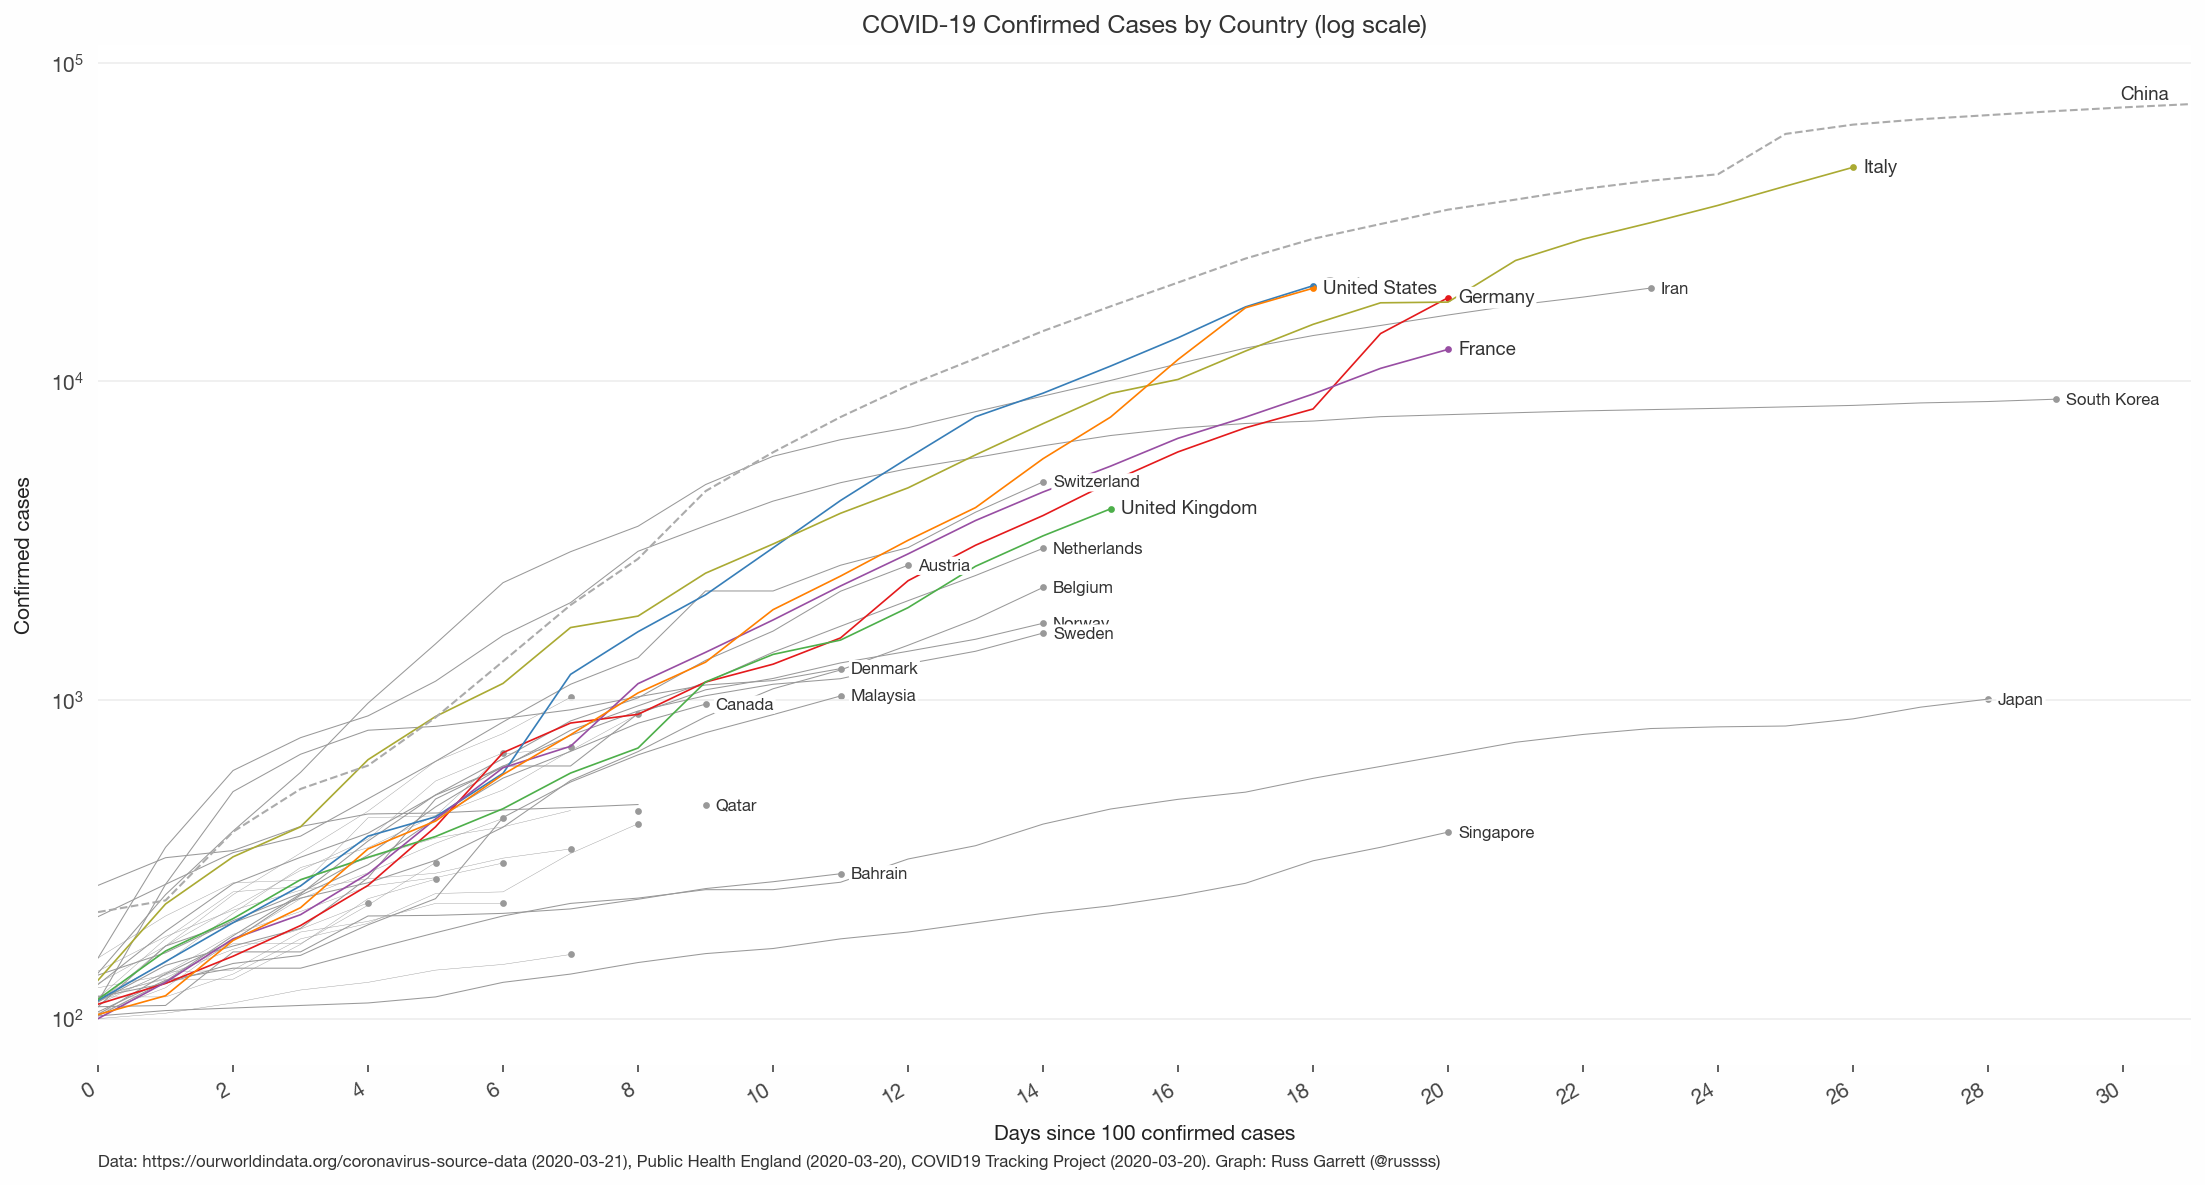

In [51]:
threshold = 100
confirmed = by_relative_date(by_country(data), threshold=threshold, past_days=0)
ax = plt.axes()

maxdate = timedelta(days=-10)
DAY = 60*60*24*10**9

countries = ['Finland', 'Czech Republic', 'Philippines', 'Israel', 'Slovenia', 'Iceland', 'Ireland',
            'Romania', 'Portugal', 'Poland', 'Indonesia', 'India', 'Kuwait', 'Saudi Arabia']
label_countries = ['Japan', 'Belgium', 'Netherlands', 'Norway', 'Singapore', 'Malaysia', 'Sweden',
             'Switzerland', 'South Korea', 'Iran', 'Denmark', 'Qatar', 'Canada', 'Austria', 'Bahrain']
highlight_countries = ['Germany', 'Spain', 'United Kingdom', 'France', 'Italy', 'United States']

colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3', '#aaaa33', '#ff7f00']

custom_offset = {
    #'Netherlands': (5, 2),
    #'Norway': (5, 4),
    #'Belgium': (5, -4),
    #'Sweden': (5, -20)
}

i = 0
for country in countries + label_countries + highlight_countries:
    if country in highlight_countries:
        color = colors[i]
        i += 1
    else:
        color = '#999999'
    
    series = extract_country(confirmed, country, True)
    if len(series) == 0:
        raise Exception(f"No data for {country}")
    
    if country in countries:
        linewidth = 0.2
    elif country in label_countries:
        linewidth = 0.5
    else:
        linewidth = 0.8
    
    series.plot(ax=ax, y='total_cases', label=country, linewidth=linewidth, color=color, logy=True)
    maxdate = max(maxdate, series.index.max())

    size = 8
    if country in highlight_countries:
        size = 9
        
    show_label = (country in label_countries or country in highlight_countries)

    add_ending_dot(plt, series, country, 'total_cases', size=size, color=[color],
                   text_offset=custom_offset.get(country, (10, -5)),
                   show_label=show_label)

maxx = (maxdate.days + 2)

series = extract_country(confirmed, 'China', True)
series.plot(ax=ax, linewidth=1, y='total_cases', color="#ababab", linestyle='--', logy=True)
plt.annotate("China", 
             (maxx, series[series.index==timedelta(days=maxx)]['total_cases'][0]),
             xytext=(-70, 5), textcoords='offset pixels',
             fontsize=9)
   
def tickFormatter(x, _pos):
    return "{:.0f}".format(x)
  
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(tickFormatter))
ax.get_xaxis().set_major_locator(plt.MultipleLocator(2))

ax.set_xlim(0, maxx)

ax.get_legend().remove()

plt.xlabel(f"Days since {threshold} confirmed cases")
plt.ylabel("Confirmed cases")
plt.title("COVID-19 Confirmed Cases by Country (log scale)")
plt.grid(axis='y', which='major', color='#eeeeee')
add_attribution(plt)
plt.savefig("rate-log.png")

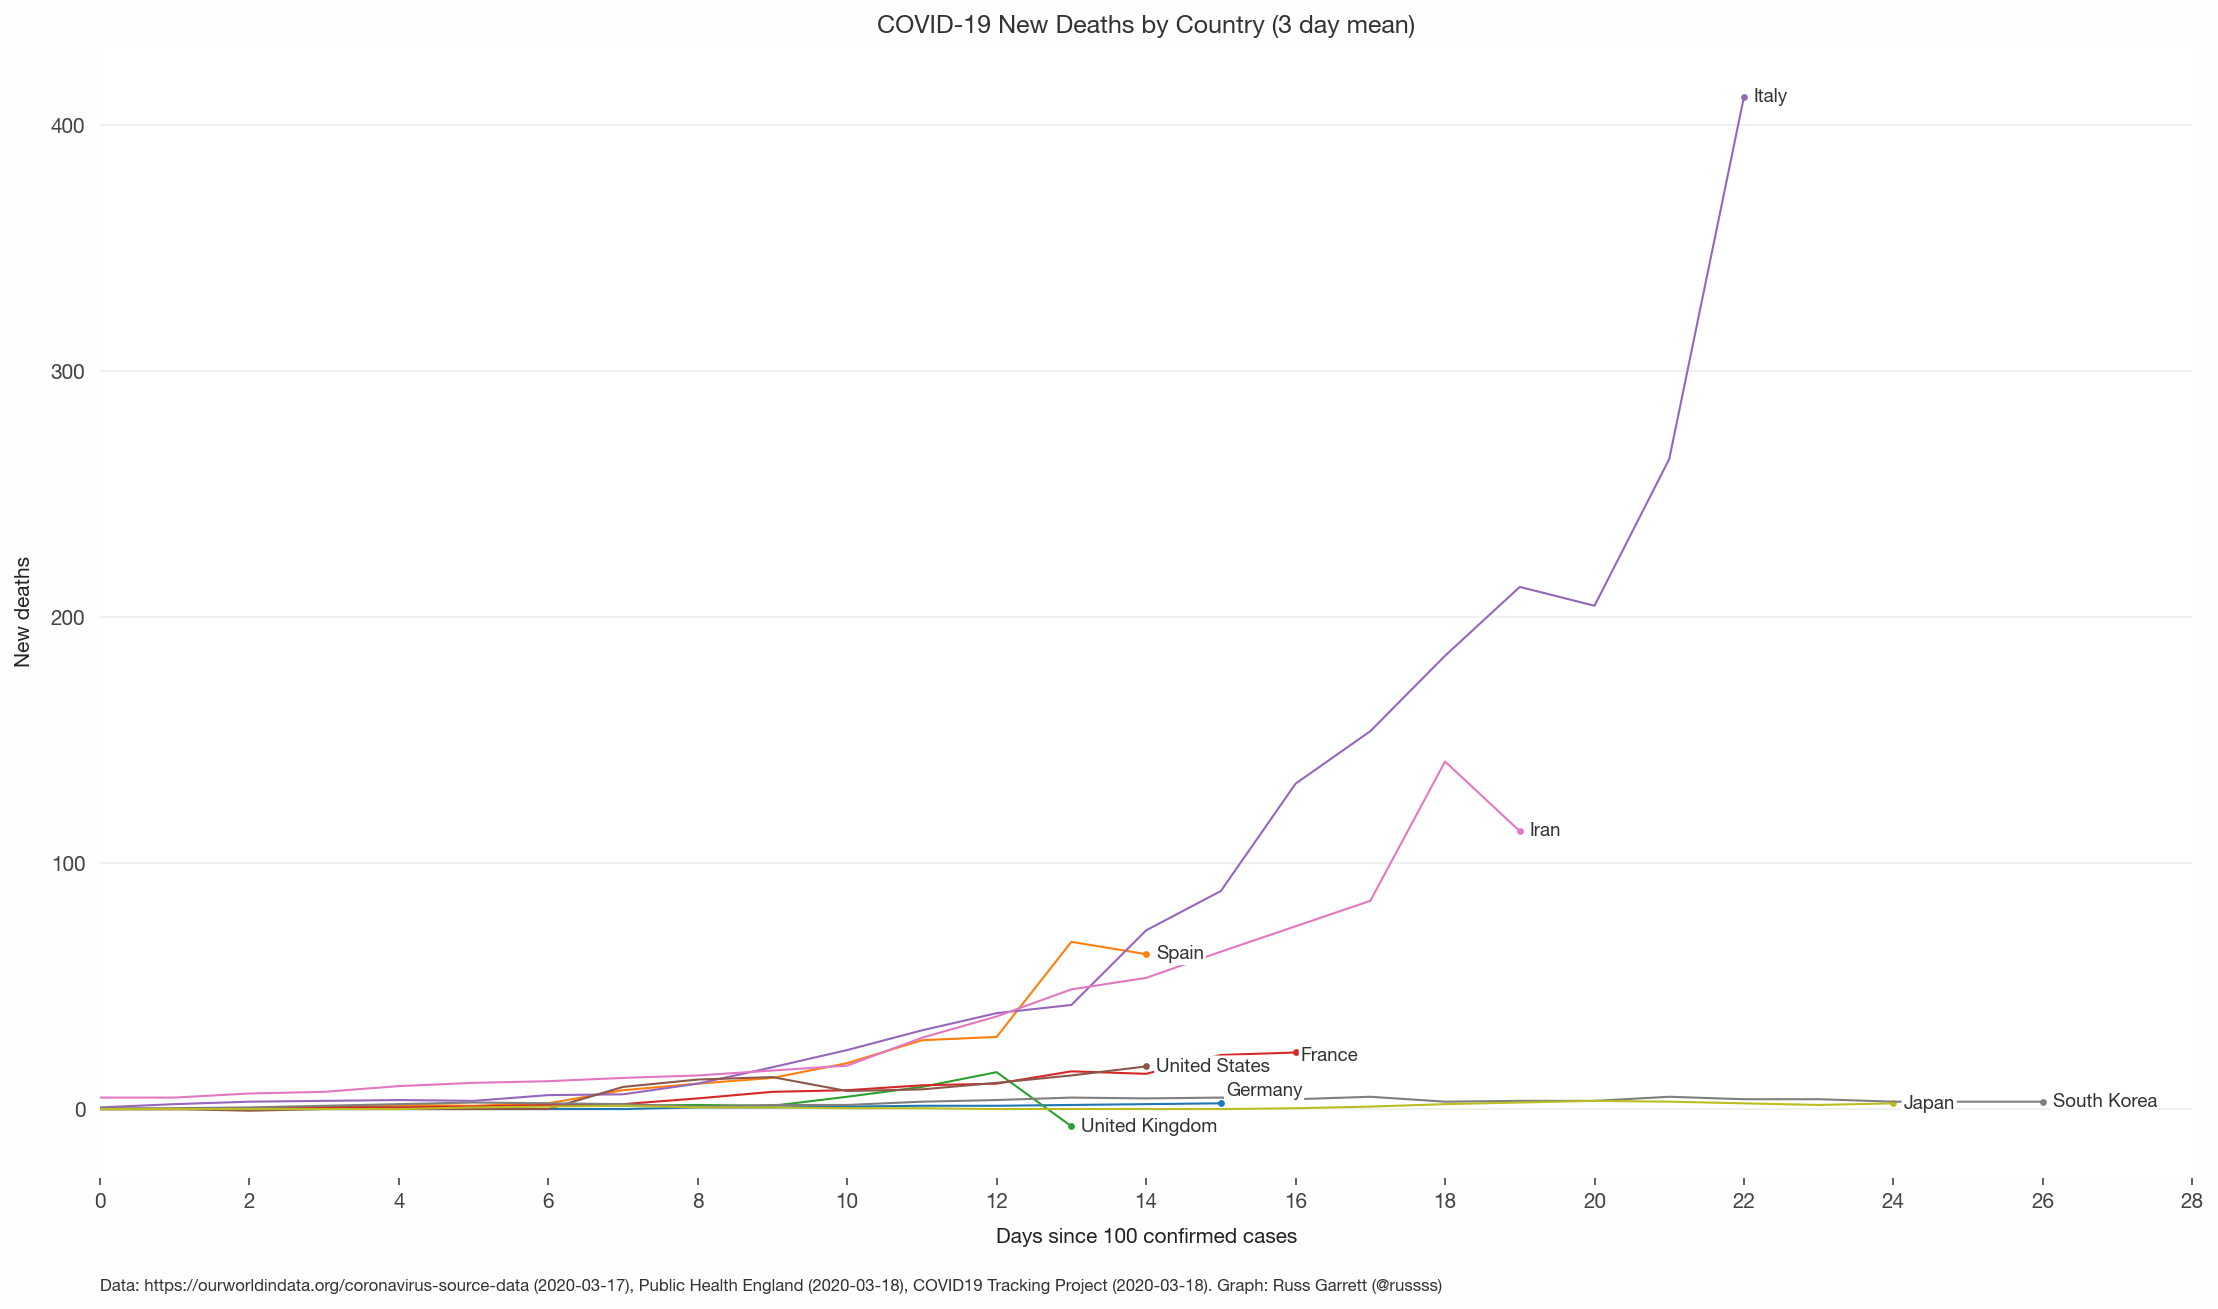

In [78]:
threshold = 100
field = 'total_deaths'
df = by_relative_date(by_country(data), threshold=threshold, past_days=4)

custom_offset = {
    'Germany': (5, 8),
    'France': (5, -8),
}

ax = plt.axes()
for country in highlight_countries + ['Iran', 'South Korea', 'Japan']:
    series = df[(df['location'] == country) & (df[field] != np.nan)]
    series = (series
              .drop(columns=['location', 'date'])
              .set_index('reltime')
              .diff().rolling(3).mean()
             )
    series.plot(ax=ax, y=field)
    add_ending_dot(plt, series, country, field,
                  text_offset=custom_offset.get(country, (10, -5)))

ax.set_xlim(0, maxx * DAY)
ax.get_legend().remove()
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(tickFormatter))
ax.get_xaxis().set_major_locator(plt.MultipleLocator(DAY*2))

if field == 'total_deaths':
    plt.title("COVID-19 New Deaths by Country (3 day mean)")
    plt.ylabel("New deaths")
elif field == 'total_cases':
    plt.title("COVID-19 New Cases by Country (3 day mean)")
    plt.ylabel("New confirmed cases")

plt.xlabel(f"Days since {threshold} confirmed cases")
plt.grid(axis='y', which='major', color='#eeeeee')
add_attribution(plt)

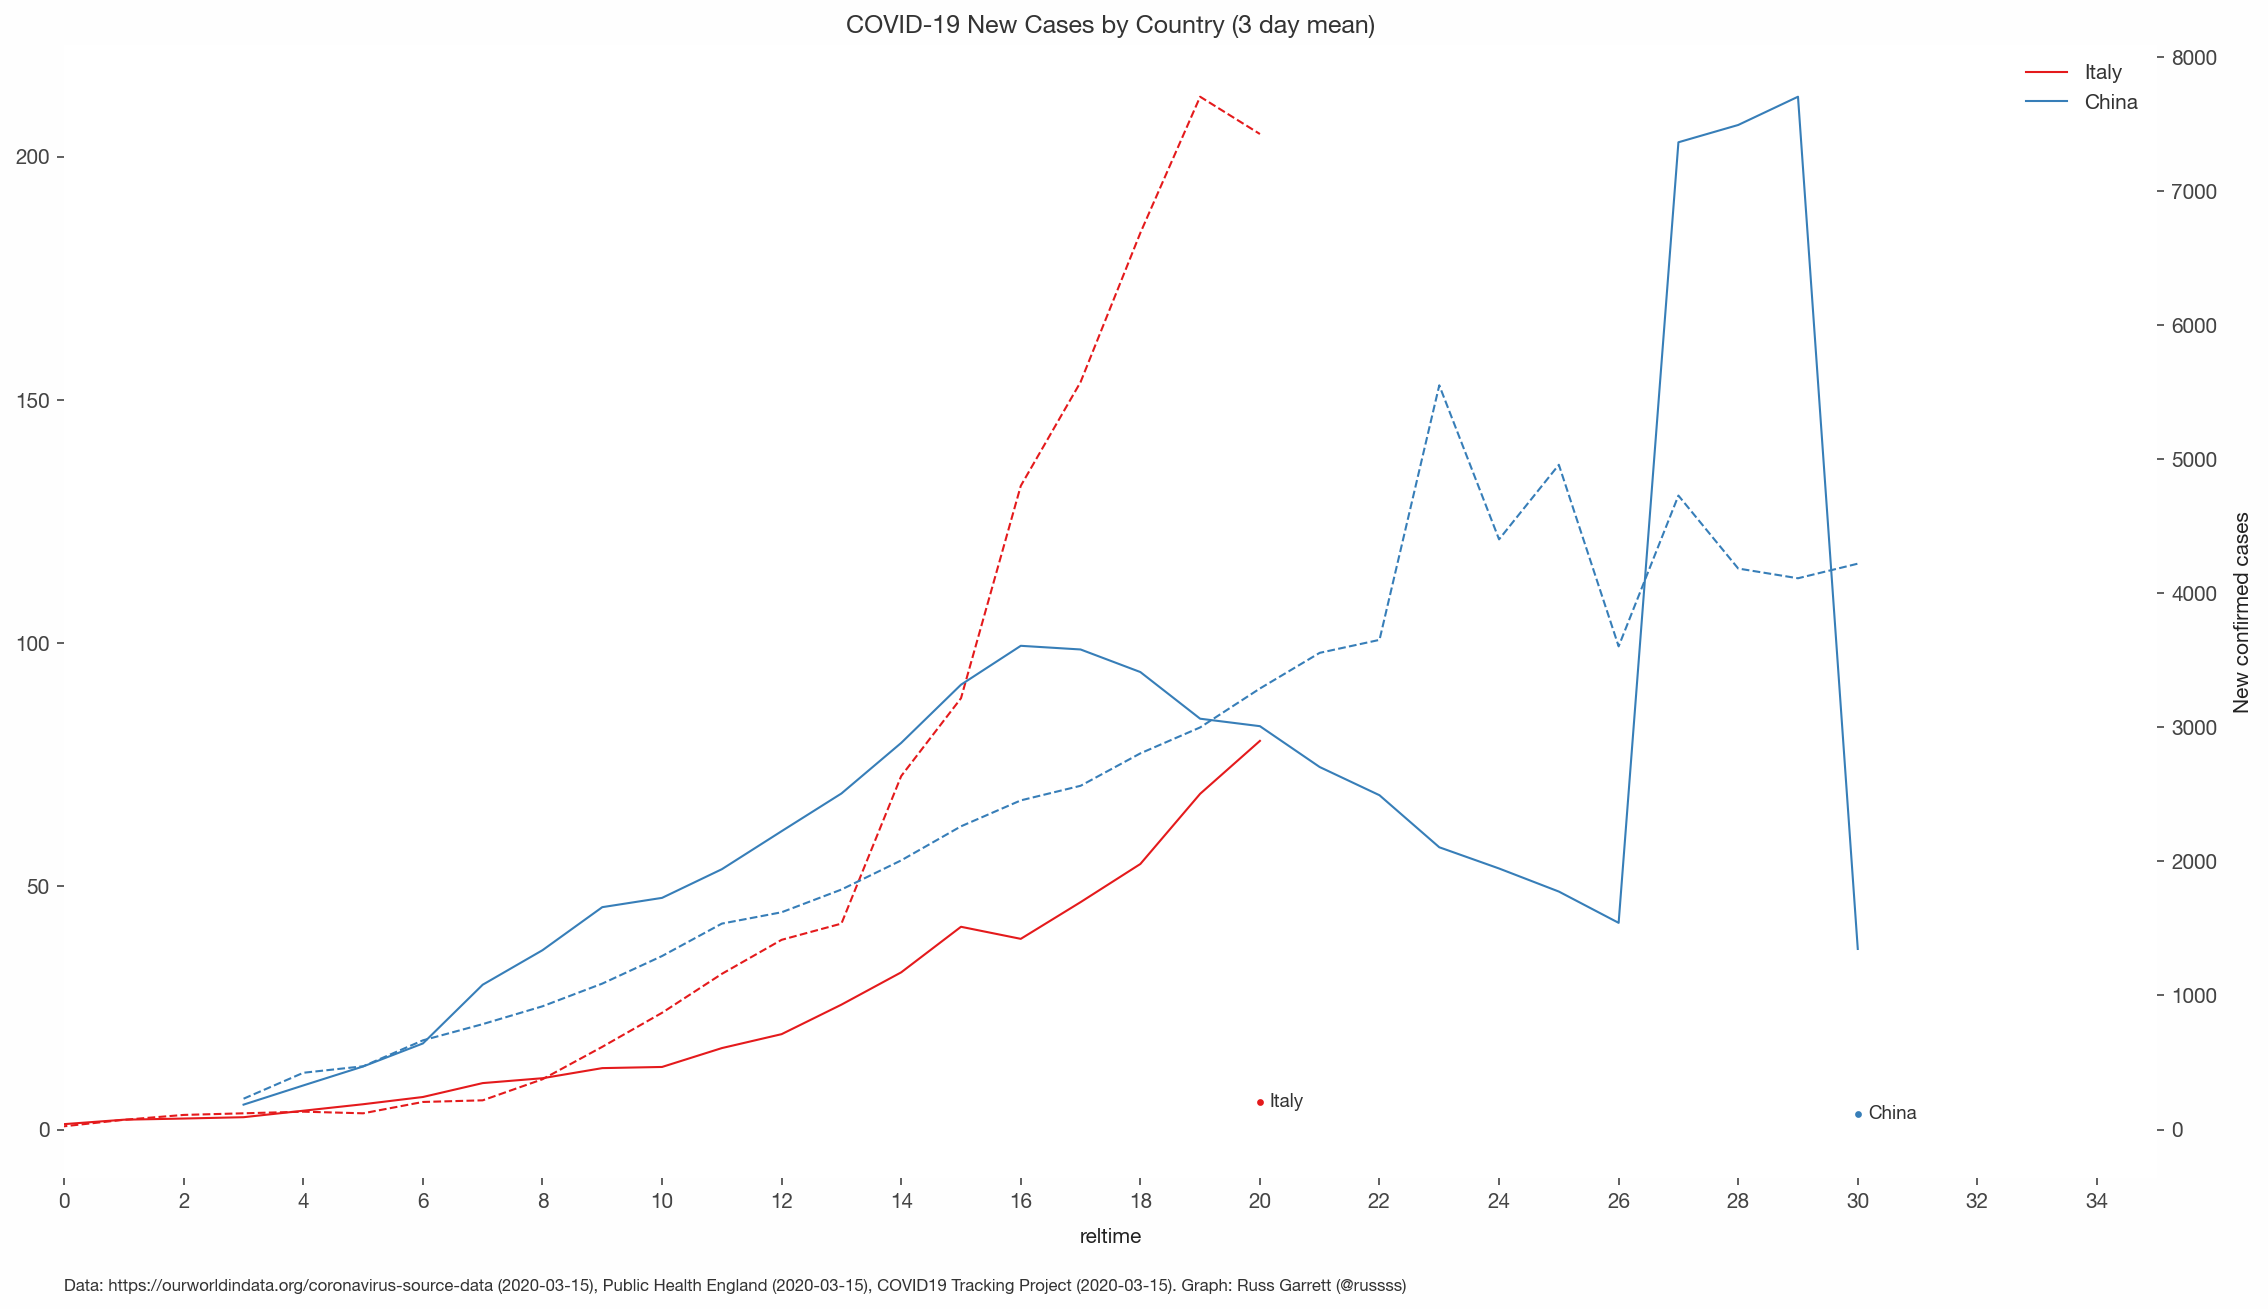

In [12]:
threshold = 100
df = by_relative_date(by_country(data), threshold=threshold, past_days=4, future_days=30)

colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3', '#aaaa33', '#ff7f00']

ax2 = plt.axes()
ax = ax2.twinx()
i = 0
for country in ['Italy', 'China']:
    series = (df[df['location'] == country]
              .drop(columns=['location', 'date'])
              .set_index('reltime')
              .diff().rolling(3).mean()
             )
    color = colors[i]
    series.plot(ax=ax, y="total_cases", label=country, color=color)
    add_ending_dot(plt, series, country, field, color=color)
    series.plot(ax=ax2, y="total_deaths", linestyle="--", color=color)
    i += 1

ax.set_xlim(0, 35 * DAY)
#ax.get_legend().remove()
ax2.get_legend().remove()
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(tickFormatter))
ax.get_xaxis().set_major_locator(plt.MultipleLocator(DAY*2))

plt.title("COVID-19 New Cases by Country (3 day mean)")
plt.ylabel("New confirmed cases")

plt.xlabel(f"Days since {threshold} confirmed cases")
#plt.grid(axis='y', which='major', color='#eeeeee')
add_attribution(plt)

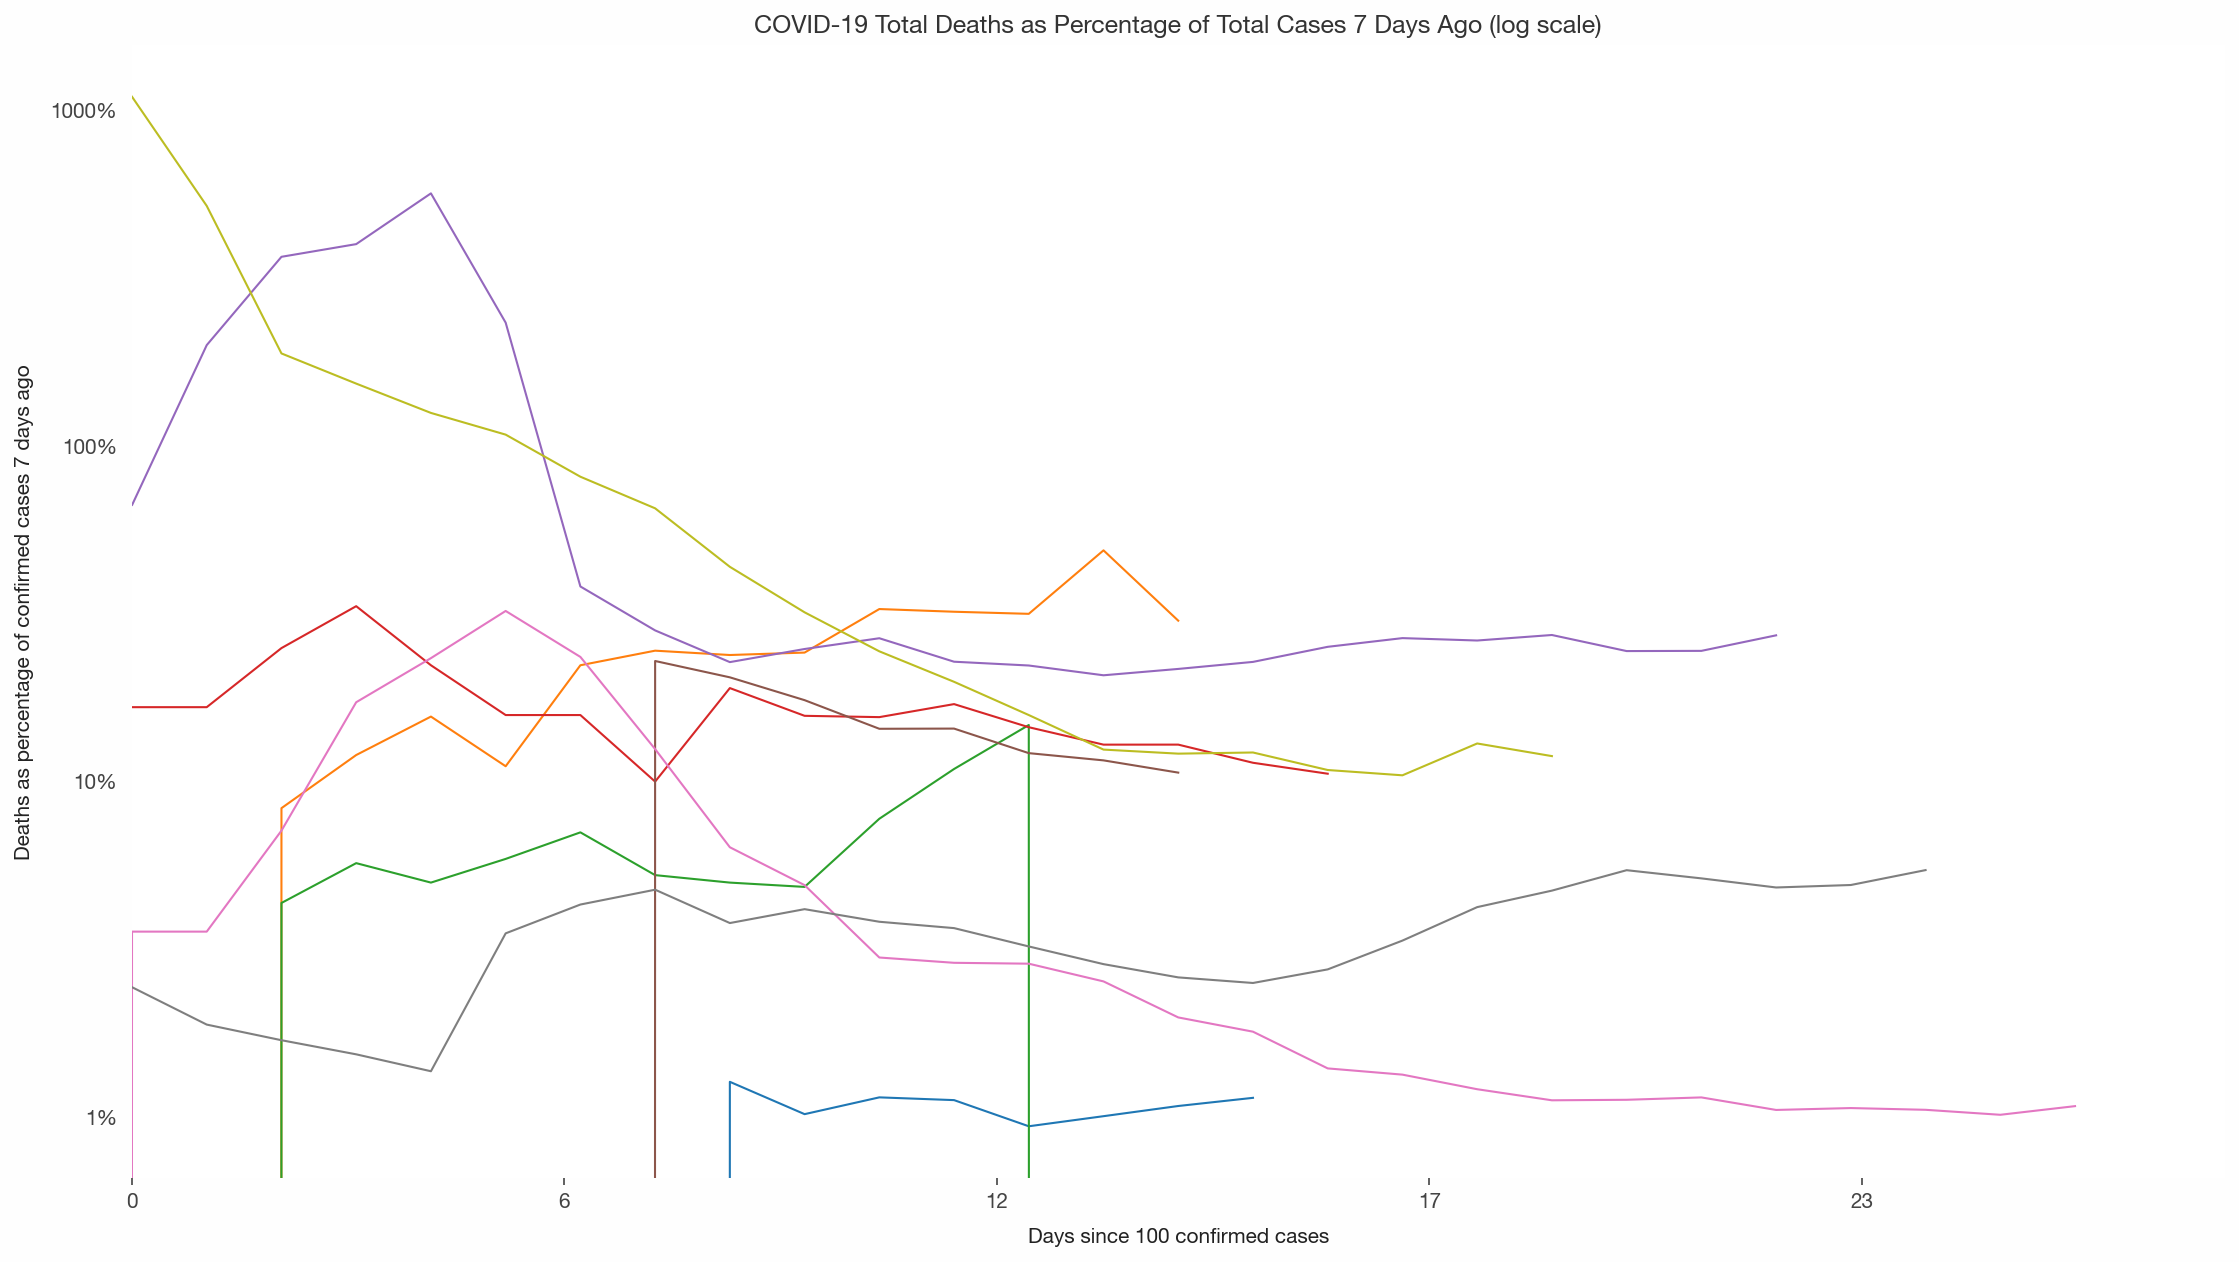

In [80]:
df = by_relative_date(by_country(data), threshold=threshold, past_days=10)
ax = plt.axes()

for country in highlight_countries + ['South Korea', 'Japan', 'Iran']:
    series = (df[df['location'] == country]
              .drop(columns=['location', 'date'])).set_index('reltime')

    series['total_cases'] = series['total_cases'].shift(7)
    series['death_ratio'] = (series['total_deaths'] / series['total_cases']) * 100
    series.plot(ax=ax, y='death_ratio', label=country, logy=True)
    #add_ending_dot(plt, series, country, 'death_ratio')

ax.set_xlim(0, maxx * DAY)
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(tickFormatter))
ax.get_yaxis().set_major_formatter(ticker.PercentFormatter())
ax.get_legend().remove()

plt.title("COVID-19 Total Deaths as Percentage of Total Cases 7 Days Ago (log scale)")
plt.ylabel("Deaths as percentage of confirmed cases 7 days ago")
plt.xlabel(f"Days since {threshold} confirmed cases")
plt.show()

In [59]:
from scipy.optimize import curve_fit

def logistic(x, L, k, x0):
    """ The logistic curve function
    
         L: maximum value of curve
         k: logistic growth rate
         x0: x-value of midpoint
    """
    return L / (1 + np.exp(-k * (x - x0)))

bounds = (
#    L  k   x0
    [0, 0, -10],
    [1, 10, 20]
)

i = 0
fits = []
countries = ['South Korea']#('Iran (Islamic Republic of)', 'Italy', 'Mainland China', 'Republic of Korea')
for country in countries:
    i += 1
    series = extract_country(confirmed, country, True)
    series[country] = series[country] / population[country] * 100

    padding_data = pd.DataFrame(
        index=[timedelta(days=d) for d in range(series.index.days.min() - 30, series.index.days.min())],
        data={country: [0] * 30})

    series = pd.concat([padding_data, series])

    fit, pcov = curve_fit(logistic, series.index.days, series[country],
                           bounds=bounds)

    fits.append(fit)
    perr = np.sqrt(np.diag(pcov))

    print(f"{country} L: {fit[0]}% ({round(fit[0] / 100 * population[country], 0)}), k: {fit[1]}, x0: {fit[2]}")
    fit_index = pd.TimedeltaIndex(data=[timedelta(days=i) for i in range(-30, 60)])
    fitted_curve = pd.DataFrame(index=fit_index, data={'Fit': logistic(fit_index.days, *fit)})

    ax = plt.subplot(math.ceil(len(countries) / 2), math.ceil(len(countries) / 2), i)
    series.plot(ax=ax)
    fitted_curve.plot(ax=ax, linestyle='--')
    plt.grid(axis='y', which='major', color='#eeeeee')
    ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(tickFormatter))
    ax.get_yaxis().set_major_formatter(ticker.PercentFormatter())
    plt.xlabel("Days since 100 confirmed cases")
    plt.ylabel("Percent of population infected")
    
mean_fit = np.mean(fits, axis=0)
print(f"Mean fit L: {mean_fit[0]}, k: {mean_fit[1]}, x0: {mean_fit[2]}")
plt.show()

KeyError: 'South Korea'